# Import Dataset & Upload Kaggle

In [1]:
# Library utama
import numpy as np
import pandas as pd
import os
import shutil
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Upload file kaggle.json untuk akses dataset
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sahrazulqaidah","key":"f579b99f1dfbfdccc01270b5948a20b1"}'}

In [2]:
# Simpan kaggle.json ke direktori ~/.kaggle
os.makedirs(os.path.expanduser('~/.kaggle'), exist_ok=True)
shutil.move("kaggle.json", os.path.expanduser("~/.kaggle/kaggle.json"))

# Ubah permission agar bisa diakses
os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)

# Download Dataset
!kaggle datasets download -d datamunge/sign-language-mnist

Dataset URL: https://www.kaggle.com/datasets/datamunge/sign-language-mnist
License(s): CC0-1.0
 78% 49.0M/62.6M [00:00<00:00, 190MB/s]
100% 62.6M/62.6M [00:00<00:00, 206MB/s]


In [3]:
import zipfile

with zipfile.ZipFile("sign-language-mnist.zip", "r") as zip_ref:
    zip_ref.extractall("sign_mnist_data")

# Load, Label, dan Split Data

In [4]:
# Load data train dan test dari file CSV
train_df = pd.read_csv("sign_mnist_data/sign_mnist_train.csv")
test_df = pd.read_csv("sign_mnist_data/sign_mnist_test.csv")

# Gabungkan data train dan test
full_df = pd.concat([train_df, test_df], axis=0).reset_index(drop=True)

# Pisahkan label dan fitur
X = full_df.drop("label", axis=1).values
y = full_df["label"].values

# Normalisasi dan reshape
X = X / 255.0
X = X.reshape(-1, 28, 28, 1)

# Encode label ke one-hot
encoder = LabelEncoder()
y_enc = encoder.fit_transform(y)
y_cat = to_categorical(y_enc)

# Split menjadi train, val, dan test
X_train, X_temp, y_train, y_temp = train_test_split(X, y_cat, test_size=0.3, random_state=42, stratify=y_cat)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Cek hasil
print("X_train:", X_train.shape)
print("X_val:", X_val.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_val:", y_val.shape)
print("y_test:", y_test.shape)

X_train: (24238, 28, 28, 1)
X_val: (5194, 28, 28, 1)
X_test: (5195, 28, 28, 1)
y_train: (24238, 24)
y_val: (5194, 24)
y_test: (5195, 24)


# Data Augmentation

In [5]:
# Data Augmentation
train_datagen = ImageDataGenerator(
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator()  # Tidak ada augmentasi untuk val/test

# Buat generator
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
val_generator = val_datagen.flow(X_val, y_val, batch_size=32)

# CNN Model Training

In [7]:
# Model CNN
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(y_train.shape[1], activation='softmax')  # output layer
])

# Kompilasi
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callback untuk early stopping dan best model saving
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint("best_model.h5", monitor='val_accuracy', save_best_only=True)

# Training
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=[early_stop, checkpoint]
)

Epoch 1/30
758/758 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.1298 - loss: 2.8427

758/758 ━━━━━━━━━━━━━━━━━━━━ 36s 44ms/step - accuracy: 0.1300 - loss: 2.8422 - val_accuracy: 0.5940 - val_loss: 1.3393
Epoch 2/30
757/758 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.4217 - loss: 1.7258

758/758 ━━━━━━━━━━━━━━━━━━━━ 31s 40ms/step - accuracy: 0.4218 - loss: 1.7255 - val_accuracy: 0.6765 - val_loss: 0.9541
Epoch 3/30
757/758 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.5291 - loss: 1.3728

758/758 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.5291 - loss: 1.3726 - val_accuracy: 0.8038 - val_loss: 0.6276
Epoch 4/30
758/758 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5995 - loss: 1.1533

758/758 ━━━━━━━━━━━━━━━━━━━━ 32s 42ms/step - accuracy: 0.5995 - loss: 1.1533 - val_accuracy: 0.8159 - val_loss: 0.5416
Epoch 5/30
758/758 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.6429 - loss: 1.0257

758/758 ━━━━━━━━━━━━━━━━━━━━ 32s 43ms/step - accuracy: 0.6429 - loss: 1.0257 - val_accuracy: 0.8483 - val_loss: 0.4301
Epoch 6/30
757/758 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.6805 - loss: 0.9049

758/758 ━━━━━━━━━━━━━━━━━━━━ 31s 41ms/step - accuracy: 0.6806 - loss: 0.9049 - val_accuracy: 0.8714 - val_loss: 0.3883
Epoch 7/30
758/758 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7108 - loss: 0.8262

758/758 ━━━━━━━━━━━━━━━━━━━━ 32s 42ms/step - accuracy: 0.7108 - loss: 0.8262 - val_accuracy: 0.9093 - val_loss: 0.2930
Epoch 8/30
758/758 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.7380 - loss: 0.7594

758/758 ━━━━━━━━━━━━━━━━━━━━ 32s 43ms/step - accuracy: 0.7380 - loss: 0.7594 - val_accuracy: 0.9111 - val_loss: 0.2635
Epoch 9/30
757/758 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.7535 - loss: 0.7163

758/758 ━━━━━━━━━━━━━━━━━━━━ 34s 44ms/step - accuracy: 0.7535 - loss: 0.7162 - val_accuracy: 0.9120 - val_loss: 0.2595
Epoch 10/30
758/758 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.7744 - loss: 0.6492

758/758 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.7744 - loss: 0.6492 - val_accuracy: 0.9497 - val_loss: 0.1787
Epoch 11/30
757/758 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.7840 - loss: 0.6203

758/758 ━━━━━━━━━━━━━━━━━━━━ 40s 44ms/step - accuracy: 0.7840 - loss: 0.6203 - val_accuracy: 0.9573 - val_loss: 0.1479
Epoch 12/30
757/758 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7926 - loss: 0.5907

758/758 ━━━━━━━━━━━━━━━━━━━━ 31s 41ms/step - accuracy: 0.7926 - loss: 0.5907 - val_accuracy: 0.9594 - val_loss: 0.1389
Epoch 13/30
758/758 ━━━━━━━━━━━━━━━━━━━━ 33s 43ms/step - accuracy: 0.8122 - loss: 0.5497 - val_accuracy: 0.9549 - val_loss: 0.1454
Epoch 14/30
758/758 ━━━━━━━━━━━━━━━━━━━━ 31s 41ms/step - accuracy: 0.8109 - loss: 0.5537 - val_accuracy: 0.9534 - val_loss: 0.1274
Epoch 15/30
757/758 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8249 - loss: 0.5132

758/758 ━━━━━━━━━━━━━━━━━━━━ 33s 44ms/step - accuracy: 0.8249 - loss: 0.5132 - val_accuracy: 0.9736 - val_loss: 0.1030
Epoch 16/30
758/758 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8288 - loss: 0.5005

758/758 ━━━━━━━━━━━━━━━━━━━━ 32s 42ms/step - accuracy: 0.8288 - loss: 0.5005 - val_accuracy: 0.9807 - val_loss: 0.0862
Epoch 17/30
758/758 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8322 - loss: 0.4823

758/758 ━━━━━━━━━━━━━━━━━━━━ 42s 43ms/step - accuracy: 0.8322 - loss: 0.4823 - val_accuracy: 0.9819 - val_loss: 0.0841
Epoch 18/30
758/758 ━━━━━━━━━━━━━━━━━━━━ 33s 43ms/step - accuracy: 0.8450 - loss: 0.4517 - val_accuracy: 0.9713 - val_loss: 0.0994
Epoch 19/30
757/758 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8489 - loss: 0.4380

758/758 ━━━━━━━━━━━━━━━━━━━━ 33s 44ms/step - accuracy: 0.8489 - loss: 0.4380 - val_accuracy: 0.9825 - val_loss: 0.0787
Epoch 20/30
758/758 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.8534 - loss: 0.4161 - val_accuracy: 0.9800 - val_loss: 0.0768
Epoch 21/30
758/758 ━━━━━━━━━━━━━━━━━━━━ 31s 41ms/step - accuracy: 0.8562 - loss: 0.4242 - val_accuracy: 0.9752 - val_loss: 0.0773
Epoch 22/30
758/758 ━━━━━━━━━━━━━━━━━━━━ 33s 43ms/step - accuracy: 0.8660 - loss: 0.3964 - val_accuracy: 0.9773 - val_loss: 0.0820
Epoch 23/30
758/758 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8710 - loss: 0.3773

758/758 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.8710 - loss: 0.3773 - val_accuracy: 0.9886 - val_loss: 0.0536
Epoch 24/30
758/758 ━━━━━━━━━━━━━━━━━━━━ 32s 42ms/step - accuracy: 0.8611 - loss: 0.3850 - val_accuracy: 0.9852 - val_loss: 0.0555
Epoch 25/30
758/758 ━━━━━━━━━━━━━━━━━━━━ 33s 44ms/step - accuracy: 0.8727 - loss: 0.3633 - val_accuracy: 0.9807 - val_loss: 0.0625
Epoch 26/30
758/758 ━━━━━━━━━━━━━━━━━━━━ 31s 41ms/step - accuracy: 0.8770 - loss: 0.3568 - val_accuracy: 0.9871 - val_loss: 0.0525
Epoch 27/30
758/758 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.8791 - loss: 0.3589

758/758 ━━━━━━━━━━━━━━━━━━━━ 32s 43ms/step - accuracy: 0.8791 - loss: 0.3589 - val_accuracy: 0.9925 - val_loss: 0.0403
Epoch 28/30
758/758 ━━━━━━━━━━━━━━━━━━━━ 41s 42ms/step - accuracy: 0.8816 - loss: 0.3397 - val_accuracy: 0.9881 - val_loss: 0.0455
Epoch 29/30
758/758 ━━━━━━━━━━━━━━━━━━━━ 31s 40ms/step - accuracy: 0.8760 - loss: 0.3667 - val_accuracy: 0.9925 - val_loss: 0.0338
Epoch 30/30
758/758 ━━━━━━━━━━━━━━━━━━━━ 43s 43ms/step - accuracy: 0.8874 - loss: 0.3287 - val_accuracy: 0.9861 - val_loss: 0.0439


# Evaluasi Model di Data Uji

In [8]:
# Buat test generator (tanpa augmentasi)
test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow(X_test, y_test, batch_size=32, shuffle=False)

# Evaluasi model
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9913 - loss: 0.0365
Test Accuracy: 0.9915
Test Loss: 0.0358


# Plot Akurasi & Loss

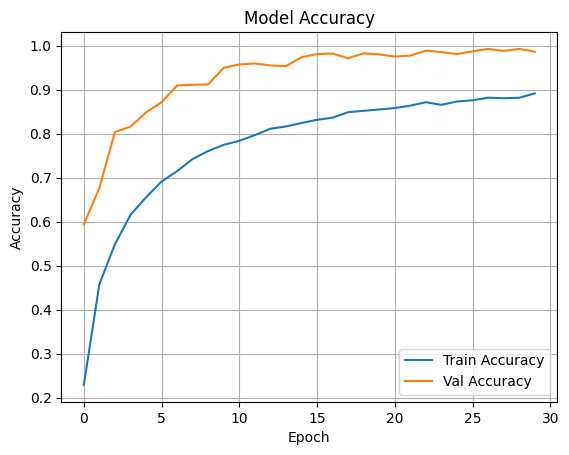

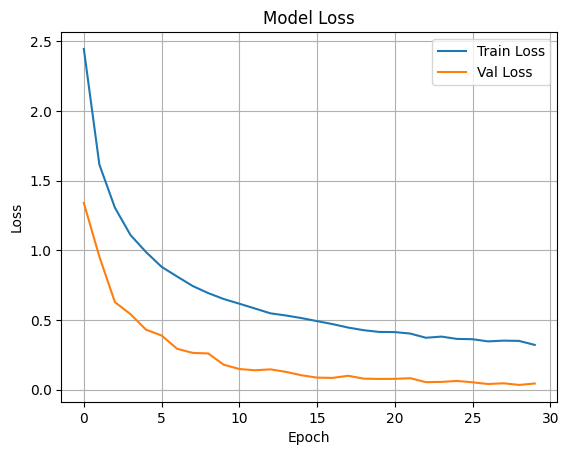

In [9]:
# Akurasi
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Ekspor Model ke Format SavedModel

In [10]:
# Simpan ke format SavedModel
model.export("saved_model")

Saved artifact at 'saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name='keras_tensor_11')
Output Type:
  TensorSpec(shape=(None, 24), dtype=tf.float32, name=None)
Captures:
  135215054750352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135215054752080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135215054751504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135215054752848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135215054752272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135215054753616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135215054753040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135215054754384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135215054753808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135215054755152: TensorSpec(shape=(), dtype=tf.resource, name=None)


# Ekspor ke Format TFLite

In [12]:
# Converter
converter = tf.lite.TFLiteConverter.from_saved_model("saved_model")
tflite_model = converter.convert()

# Simpan model
os.makedirs("tflite", exist_ok=True)
with open("tflite/model.tflite", "wb") as f:
    f.write(tflite_model)

In [13]:
with open("tflite/label.txt", "w") as f:
    for label in encoder.classes_:
        f.write(f"{label}\n")

# Ekspor ke Format TensorFlow.js

In [1]:
!pip install tensorflowjs

!tensorflowjs_converter \
    --input_format=tf_saved_model \
    --output_format=tfjs_graph_model \
    saved_model \
    tfjs_model

2025-06-27 12:46:14.470189: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751028374.558830    5533 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751028374.609434    5533 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-27 12:46:14.720638: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2025-0

# INFERENCE

## Inference: Menguji Kembali Model Setelah Training

Setelah model dilatih dan disimpan ke dalam tiga format ekspor (SavedModel, TFLite, dan TensorFlow.js), langkah selanjutnya adalah **melakukan inference (prediksi)** menggunakan model yang telah disimpan.

### Mengapa Perlu Load Ulang Model?

Karena **runtime Google Colab dapat ter-restart secara otomatis**, maka seluruh variabel yang tersimpan dalam memori sebelumnya akan hilang, termasuk model yang sudah terlatih. Oleh karena itu, kita perlu:
- **Muat ulang model dari file SavedModel atau TFLite**
- **Muat ulang data uji (X_test dan label)**
- **Muat ulang LabelEncoder** untuk menginterpretasikan hasil prediksi ke label aslinya.

## Persiapan: Load Dataset Uji

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Muat ulang data uji
test_df = pd.read_csv("sign_mnist_data/sign_mnist_test.csv")
X_test = test_df.drop("label", axis=1).values.reshape(-1, 28, 28, 1).astype("float32") / 255.0
y_test = test_df["label"].values

# Encode label asli
encoder = LabelEncoder()
encoder.fit(y_test)  # Bisa juga gunakan label lengkap A-Y
y_test_enc = encoder.transform(y_test)

# Contoh label kelas
print("Daftar label:", list(encoder.classes_))

Daftar label: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24)]


## Inference Menggunakan TFLite

In [3]:
import tensorflow as tf

# Load model TFLite
interpreter = tf.lite.Interpreter(model_path="tflite/model.tflite")
interpreter.allocate_tensors()

# Ambil detail tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Inference pada 10 sampel pertama
for i in range(10):
    sample = X_test[i:i+1]
    interpreter.set_tensor(input_details[0]['index'], sample)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details[0]['index'])

    pred_label = np.argmax(output)
    print(f"Sampel {i+1}: Prediksi = {encoder.classes_[pred_label]}, Asli = {encoder.classes_[y_test_enc[i]]}")

Sampel 1: Prediksi = 6, Asli = 6
Sampel 2: Prediksi = 5, Asli = 5
Sampel 3: Prediksi = 10, Asli = 10
Sampel 4: Prediksi = 0, Asli = 0
Sampel 5: Prediksi = 3, Asli = 3
Sampel 6: Prediksi = 21, Asli = 21
Sampel 7: Prediksi = 10, Asli = 10
Sampel 8: Prediksi = 14, Asli = 14
Sampel 9: Prediksi = 3, Asli = 3
Sampel 10: Prediksi = 7, Asli = 7
